Resources: 
- https://www.kaggle.com/ferneutron/feature-extraction-with-different-methods
- https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2

## Setting up

In [227]:
import pandas as pd # To handle the data set.
import seaborn as sb # To display visualizations.
import matplotlib.pyplot as plt # To plot
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import confusion_matrix # To calculate the confusion matrix
from sklearn.metrics import accuracy_score # To calculate the score
from sklearn.feature_selection import SelectKBest # Univariate Feature Selection
from sklearn.feature_selection import chi2 # To apply Univariate Feature Selection
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE # Recursive Feature Selection
from sklearn.feature_selection import RFECV # Recursive Feature Selection with Cross Validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA # To apply PCA
from sklearn import preprocessing # To get MinMax Scaler function

# To plot inline
%matplotlib inline

# Evaluation
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [228]:
df = pd.read_csv('./datasets/feature_extracted.csv'
                 , sep=',', encoding='utf-8')
df.dropna();

In [229]:
# change label into binary classification
#df_raw = df.copy() # copy of df before manipulation just in case
df = df.drop('statement', axis=1)
df.label.loc[(df['label'] >= 0.5)] = 1;
df.label.loc[(df['label'] < 0.5)] = 0;
df_target = df['label']
df_feature = df.drop('label', axis=1)

In [230]:
# remove low variance data
def variance_threshold(df, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit_transform(df)
    return df[df.columns[selector.get_support(indices=True)]]

# any column with a probability of having 0 variance above 0.8 will be eliminated
df_feature = variance_threshold(df_feature, (.8 * (1 - .8)))

In [231]:
# Initializing the MinMaxScaler function
min_max_scaler = preprocessing.MinMaxScaler()
#standard_scaler = preprocessing.StandardScaler()

# Scaling dataset keeping the columns name
df_feature_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_feature), columns = df_feature.columns)
#X_scaled = pd.DataFrame(standard_scaler.fit_transform(X), columns = X.columns)

In [232]:
# Splitting  up data, seting 80% for train and 20% for test.
x_train, x_test, y_train, y_test = train_test_split(
    df_feature_scaled, df_target, test_size=0.2, random_state=42)

## Univariate selection

### Chi2

In [233]:
# Initialize SelectKBest function
selector_chi2 = SelectKBest(chi2,k=5).fit(x_train, y_train)

In [234]:
# Creating a dict to visualize which features were selected with the highest score
feature_dict_chi2 = {key:value for (key, value) in zip(
    selector_chi2.scores_, x_train.columns)}
sorted(feature_dict_chi2.items())[-k:]

[(2.12100789833749, 'num_$'),
 (3.6670420509919124, 'count_they'),
 (7.762623548602839, 'count_insight'),
 (7.785147779769392, 'count_ingest'),
 (7.794872294190457, 'count_interrog')]

In [235]:
x_train_chi2 = selector_chi2.transform(x_train)
x_test_chi2 = selector_chi2.transform(x_test)

## Anova

In [236]:
# Initialize SelectKBest function
selector_anova = SelectKBest(f_classif, k=5).fit(x_train, y_train)

In [237]:
feature_dict_anova = {key:value for (key, value) in zip(
    selector_anova.scores_, x_train.columns)}
sorted(feature_dict_anova.items())[-k:]

[(40.723387608855056, 'count_they'),
 (41.28459554180016, 'count_uppercase'),
 (66.54086624121476, 'count_insight'),
 (66.74845399583086, 'count_ingest'),
 (66.83310853853152, 'count_interrog')]

In [238]:
x_train_anova = selector_anova.transform(x_train)
x_test_anova = selector_anova.transform(x_test)

## Mutual information

In [239]:
selector_mutual = SelectKBest(mutual_info_classif, k=5)
x_train_mutual = selector_mutual.fit_transform(x_train, y_train)

In [240]:
feature_dict_anova = {key:value for (key, value) in zip(
    selector_anova.scores_, x_train.columns)}
sorted(feature_dict_anova.items())[-k:]

[(40.723387608855056, 'count_they'),
 (41.28459554180016, 'count_uppercase'),
 (66.54086624121476, 'count_insight'),
 (66.74845399583086, 'count_ingest'),
 (66.83310853853152, 'count_interrog')]

In [241]:
x_train_mutual = selector_mutual.transform(x_train)
x_test_mutual = selector_mutual.transform(x_test)

## Recursive Feature Elimination

In [242]:
# Initializing Random Forest Classifier
RandForest_RFE = RandomForestClassifier() 
# Initializing the RFE object, one of the most important arguments is the estimator, in this case is RandomForest
rfe = RFE(estimator=RandForest_RFE, n_features_to_select=5, step=1)
# Fit the origial dataset
rfe = rfe.fit(x_train, y_train)

In [243]:
print("Best features chosen by RFE: \n")
for i in x_train.columns[rfe.support_]:
    print(i)

Best features chosen by RFE: 

count_char
count_word
count_char_per_word
count_unique
count_uppercase


In [244]:
x_train_RFE = rfe.transform(x_train)
x_test_RFE = rfe.transform(x_test)
RandForest_RFE = RandForest_RFE.fit(x_train_RFE, y_train)
y_pred = RandForest_RFE.predict(x_test_RFE)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ',accuracy)

Accuracy:  0.5084346802667713


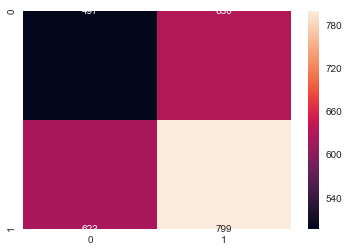

In [245]:
confMatrix = confusion_matrix(y_test, y_pred)
sb.heatmap(confMatrix, annot=True, fmt="d")

## Recursive Feature Elimination with Cross-Validation

In [246]:
# Initialize the Random Forest Classifier
RandForest_RFECV = RandomForestClassifier() 
# Initialize the RFECV function setting 3-fold cross validation
rfecv = RFECV(estimator=RandForest_RFECV, step=1, cv=3, scoring='accuracy')
# Fit data
rfecv = rfecv.fit(x_train, y_train)

print('Best number of features :', rfecv.n_features_)
print('Features :\n')
for i in x_train.columns[rfecv.support_]:
    print(i)

Best number of features : 34
Features :

num_-
num_"
num_$
num_,
num_.
count_char
count_word
count_char_per_word
count_unique
count_uppercase
count_pronoun
count_they
count_negate
count_compare
count_interrog
count_quant
count_anx
count_anger
count_insight
count_cause
count_discrep
count_certain
count_hear
count_health
count_affiliation
count_risk
count_focuspast
count_leisure
count_money
count_death
count_informal
count_swear
count_assent
count_nonflu


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Score of Selected Features')

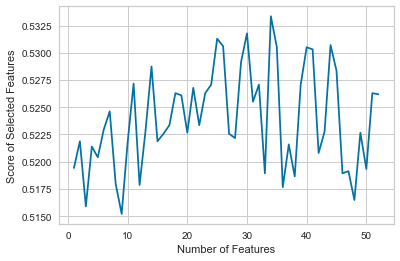

In [247]:
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Score of Selected Features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Tree based Feature Selection

In [248]:
# Initialize the Random Forest Classifier
RandForest_Tree = RandomForestClassifier()  
# Fit the random forest with the original data
RandForest_Tree = RandForest_Tree.fit(x_train, y_train)
# Getting the relevance between features
relevants = RandForest_Tree.feature_importances_

In [249]:
# Apply the tree based on importance for the random forest classifier and indexing it
std = np.std([tree.feature_importances_ for tree in RandForest_Tree.estimators_], axis=0)
indices = np.argsort(relevants)[::-1]

In [250]:
# Printting the ranking of importance
print("Feature Rank:")

for i in range(x_train.shape[1]):
    print("%d. Feature %d (%f)" 
          % (i + 1, indices[i], relevants[indices[i]]))

Feature Rank:
1. Feature 7 (0.156715)
2. Feature 5 (0.137463)
3. Feature 8 (0.089663)
4. Feature 6 (0.088048)
5. Feature 9 (0.082319)
6. Feature 11 (0.044479)
7. Feature 4 (0.041063)
8. Feature 3 (0.039065)
9. Feature 47 (0.028479)
10. Feature 0 (0.026832)
11. Feature 17 (0.018724)
12. Feature 2 (0.018291)
13. Feature 45 (0.015359)
14. Feature 34 (0.013719)
15. Feature 50 (0.011402)
16. Feature 37 (0.011239)
17. Feature 41 (0.011090)
18. Feature 1 (0.010816)
19. Feature 30 (0.010570)
20. Feature 51 (0.010282)
21. Feature 44 (0.010056)
22. Feature 48 (0.009728)
23. Feature 10 (0.008926)
24. Feature 40 (0.008458)
25. Feature 33 (0.007661)
26. Feature 29 (0.006592)
27. Feature 36 (0.006033)
28. Feature 19 (0.005958)
29. Feature 21 (0.005924)
30. Feature 28 (0.005703)
31. Feature 32 (0.005586)
32. Feature 22 (0.005471)
33. Feature 18 (0.005413)
34. Feature 46 (0.004997)
35. Feature 31 (0.004295)
36. Feature 15 (0.004049)
37. Feature 42 (0.004006)
38. Feature 24 (0.003559)
39. Feature 25 (0

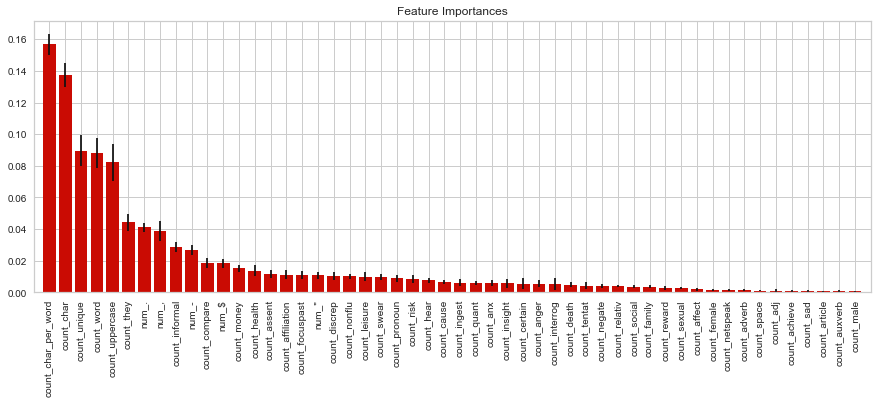

In [251]:
# Plotting the feature importances
plt.figure(1, figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), relevants[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show();

## Feature Extraction through PCA

In [252]:
# Initializing PCA and fitting
pca = PCA()
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

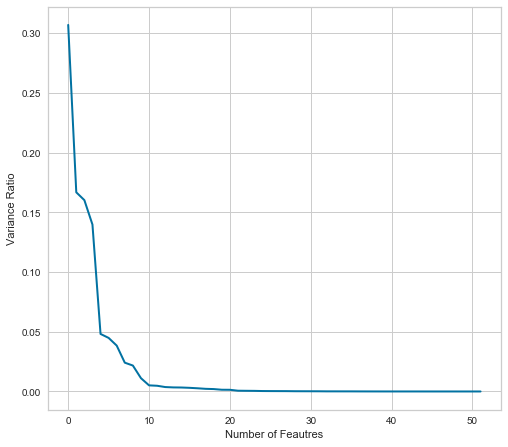

In [253]:
# Plotting to visualize the best number of elements
plt.figure(1, figsize=(9, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Feautres')
plt.ylabel('Variance Ratio')
plt.show();

## Before and after feature selection, accuracy comparison

### Random Forest

In [254]:
#All features
RandForest = RandomForestClassifier()      
RandForest = RandForest.fit(x_train, y_train)
y_pred_RF = RandForest.predict(x_test)
rf_all = accuracy_score(y_test, y_pred_RF)

In [255]:
#Chi2
RandForest_chi2 = RandomForestClassifier()      
RandForest_chi2 = RandForest_chi2.fit(x_train_chi2, y_train)
y_pred_chi2 = RandForest_K_best.predict(x_test_chi2)
rf_chi2 = accuracy_score(y_test, y_pred_chi2)

In [256]:
# Anova
RandForest_anova = RandomForestClassifier()      
RandForest_anova = RandForest_K_best.fit(x_train_anova, y_train)
y_pred_anova = RandForest_K_best.predict(x_test_anova)
rf_anova = accuracy_score(y_test, y_pred_anova)

In [257]:
# Mutual information
RandForest_mutual = RandomForestClassifier()      
RandForest_mutual = RandForest_mutual.fit(x_train_mutual, y_train)
y_pred_mutual = RandForest_K_best.predict(x_test_mutual)
rf_mutual = accuracy_score(y_test, y_pred_mutual)

In [258]:
accuracy_result = {'all features':[rf_all], 'Chi2':[rf_chi2], 'Anova':[rf_anova], 'Mutual Info':[rf_mutual]} 
df_accuracy = pd.DataFrame(accuracy_result, index =['RF', 'KNN', 'GNB', 'SVM']) 
df_accuracy

,all features,Chi2,Anova,Mutual Info
RF,0.515104,0.528835,0.554727,0.464888
KNN,0.515104,0.528835,0.554727,0.464888
GNB,0.515104,0.528835,0.554727,0.464888
SVM,0.515104,0.528835,0.554727,0.464888


In [259]:
model_logistic = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000)
model_logistic.fit(x_train, y_train)
predict = model_logistic.predict(x_test)
print("confusion matrix", confusion_matrix(y_test, predict))
print("accuracy score:", accuracy_score(y_test, predict))
print("f1 score:", f1_score(y_test, predict))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

confusion matrix [[ 224  903]
 [ 167 1255]]
accuracy score: 0.5802275402118477
f1 score: 0.7011173184357543
